<a href="https://colab.research.google.com/github/abhinavj98/machine-learning/blob/master/omniglot_oneshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/brendenlake/omniglot.git

Cloning into 'omniglot'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 78
Unpacking objects: 100% (81/81), done.


In [0]:
!ls

In [0]:
!unzip /content/omniglot/python/images_evaluation.zip
!unzip /content/omniglot/python/images_background.zip

In [0]:
!ls

images_background  images_evaluation  omniglot	sample_data


In [0]:
import os
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import time

In [0]:
def load_dataset(path):
    """Load dataset by path, returns Data values, labels and dict containg name of lang and its characters"""
    X=[]
    y = []
    cat = {}
    lang = {}
    curr_y = 0
    
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang[alphabet] = [0,None]
        alphabet_path = os.path.join(path,alphabet)
        
        for numletter, letter in enumerate(os.listdir(alphabet_path)):
          cat[numletter] = (alphabet, letter)
          category_images=[]
          letter_path = os.path.join(alphabet_path, letter)
        
          for filename in os.listdir(letter_path):
            image_path = os.path.join(letter_path, filename)
            image = imread(image_path)
            category_images.append(image)
            y.append(numletter)
          
          X.append(np.stack(category_images))
          lang[alphabet][1] = numletter - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang

In [0]:
train_path = '/content/images_background'
test_path = '/content/images_evaluation'
X_train,Y_train,lang_train = load_dataset(train_path)
X_test,Y_test,lang_test = load_dataset(test_path)


loading alphabet: Burmese_(Myanmar)
loading alphabet: Tifinagh
loading alphabet: Latin
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Korean
loading alphabet: Tagalog
loading alphabet: Braille
loading alphabet: Greek
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Early_Aramaic
loading alphabet: Japanese_(katakana)
loading alphabet: Grantha
loading alphabet: Cyrillic
loading alphabet: Sanskrit
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Japanese_(hiragana)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Armenian
loading alphabet: Arcadian
loading alphabet: Futurama
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Gujarati
loading alphabet: N_Ko
loading alphabet: Balinese
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Hebrew
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Bengali
loa

In [0]:
print(str(X_train.shape) + "   " + str(len(lang_train.keys())))
print(str(X_test.shape) + "   " + str(len(lang_test.keys())))

(964, 20, 105, 105)   30
(659, 20, 105, 105)   20


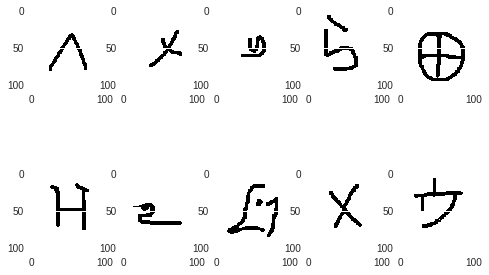

In [0]:
for i in range(10):
  temp = np.random.randint(0, X_train.shape[0])
  temp2 = np.random.randint(0, X_train.shape[1])
  plt.subplot(2,5,i+1)
  plt.imshow(X_train[temp,temp2,:,:], cmap = 'gray')
  
plt.show()

In [0]:
def get_batch(batch_size,s="train"):
    """
    Create batch of n pairs, half same class, half different class
    """
    if s == 'train':
        X = X_train
    else:
        X = X_test
    n_classes, n_examples, w, h = X.shape
    
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes,size=(batch_size,1),replace=False)
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    targets=np.zeros((batch_size,1))
    targets[batch_size//2:] = 1
    
    for i in range(batch_size):
      category = categories[i]
      index1 = np.random.randint(0, n_examples)
      pairs[0][i,:,:,:] = X[category, index1].reshape(w, h, 1)
      index2 = np.random.randint(0, n_examples)
      if i >= batch_size // 2:
        category2 = category  
      else: 
        category2 = (category + np.random.randint(1,n_classes)) % n_classes
        
      pairs[1][i,:,:,:] = X[category2,index2].reshape(w, h,1)
    
    return pairs, targets
    

In [0]:
a,b = get_batch(54)
print(a[0].shape)

(54, 105, 105, 1)


In [0]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [0]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [0]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [0]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [0]:
model = get_siamese_model((105, 105, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 4096)         38947648    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_4[1][0]               
          

In [0]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [0]:
def make_oneshot_task(N):
    X = X_test
    n_classes, n_examples, w, h = X.shape
    
    indices = np.random.randint(0, n_examples,size=(N,))
    categories = np.random.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [0]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [0]:
# Hyper parameters
evaluate_every = 100
batch_size = 32
n_iter = 20000
N_way = 20 
n_val = 250
best = -1

In [0]:
model_path = '/content/weights/'

In [0]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        

Starting training process!
-------------------------------------

 ------------- 

Time for 100 iterations: 0.303971449534 mins
Train Loss: 1.25865709782
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.4% 20 way one-shot learning accuracy 


 ------------- 

Time for 200 iterations: 0.759896600246 mins
Train Loss: 1.20657384396
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 50.0% 20 way one-shot learning accuracy 


 ------------- 

Time for 300 iterations: 1.21734739939 mins
Train Loss: 1.21267402172
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 54.4% 20 way one-shot learning accuracy 


 ------------- 

Time for 400 iterations: 1.67654774984 mins
Train Loss: 1.01059710979
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 50.4% 20 way one-shot learning accuracy 


 ------------- 

Time for 500 iterations: 2.1363180836 mins
Train Lo

array([[0.99068743]], dtype=float32)

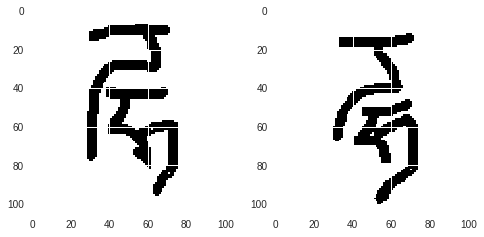

In [0]:
cat1 = 121
char1 = 1
ex1 = np.random.randint(20)
cat2 = 121
char2 = 5
ex2 = np.random.randint(20)
h = w = 105
example1 = X_test[cat1,char1,:,:].reshape(1,h,w,1)
example2 = X_test[cat2,char2,:,:].reshape(1,h,w,1)
plt.subplot(1,2,1)
plt.imshow(example1.reshape(105,105), cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(example2.reshape(105,105), cmap = 'gray')
model.predict([example1, example2])